In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Preprocessing imports
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [3]:
from sklearn.decomposition import PCA, KernelPCA

In [4]:
# Predictor imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

In [5]:
# Metric imports
from sklearn.metrics import auc, roc_auc_score

In [6]:
# Custom imports
from helper_functions import build_model

In [7]:
from helper_functions import calc_pie

### Importing data

In [8]:
df = pd.read_csv('./data/train.csv', index_col=[0])

In [9]:
df.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


### Some casual EDA

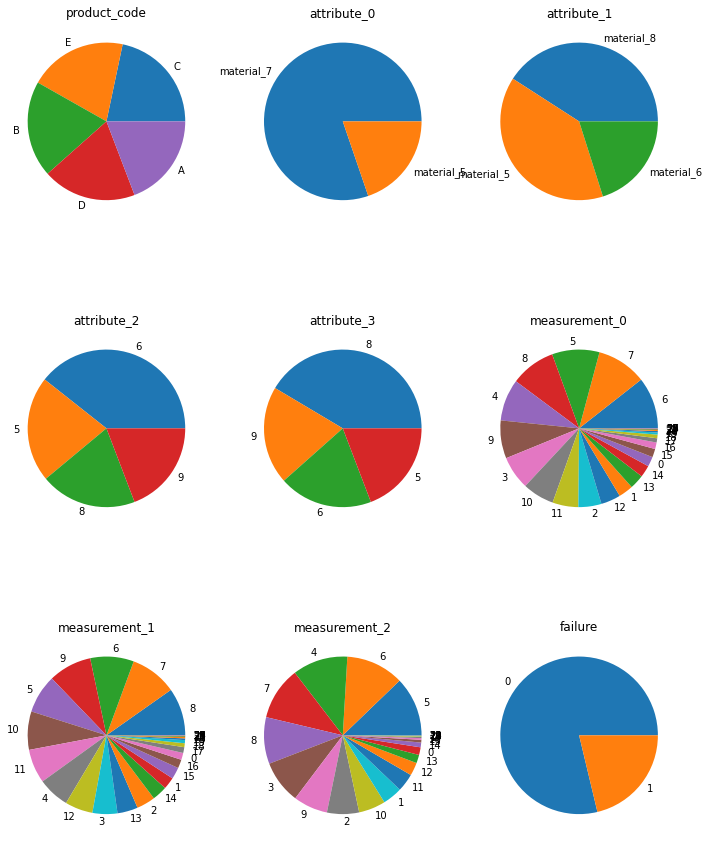

In [10]:
fig, axes = plt.subplots(3,3, figsize=(12,16))
axes = axes.flatten()
for i, item in enumerate(df.select_dtypes(['object', 'int']).iteritems()):
    pie_labels, pie_lengths = calc_pie(item[1])
    axes[i].pie(pie_lengths, labels=pie_labels)
    axes[i].set_title(item[0])

plt.savefig('pie.jpg')

In [11]:
df.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


**Main Takeaways**\
<u>Normal columns:</u> attribute1-3\

<u>Columns that require mapping (eg others):</u> measurement0-2

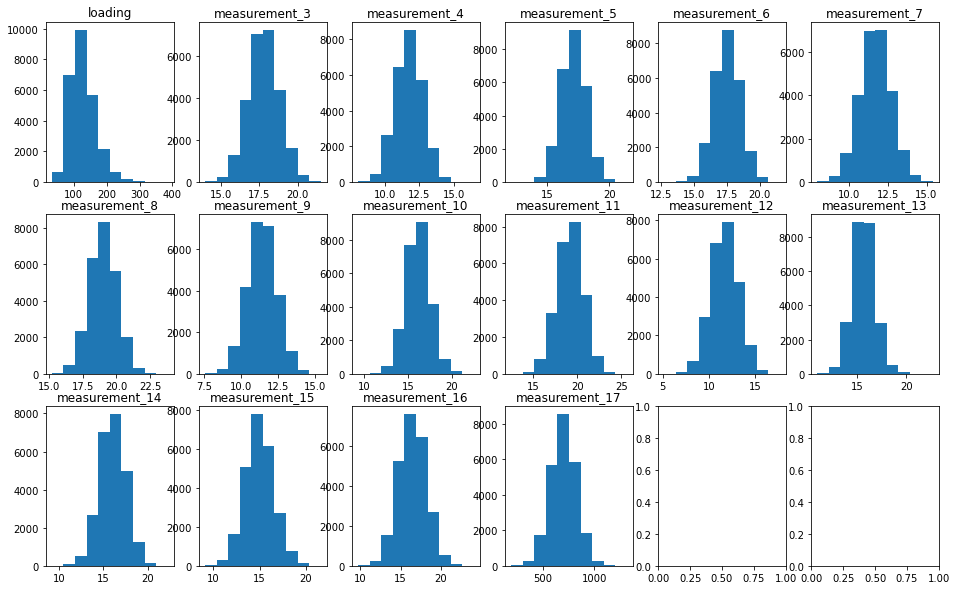

In [12]:
fig, axes = plt.subplots(3,6, figsize=(16, 10))
axes = axes.flatten()
for i , item in enumerate(df.select_dtypes(exclude=['object', 'int']).iteritems()):
    
    axes[i].hist(item[1])
    axes[i].set_title(item[0])

#### PCA - 2 components

In [13]:
X = df.drop('failure', axis=1)
y = df['failure']

In [14]:
X

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,20.155,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.889,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,18.288,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,19.060,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,18.093,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,E,158.95,material_7,material_6,6,9,6,16,4,16.301,...,19.354,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131
26566,E,146.02,material_7,material_6,6,9,10,12,8,17.543,...,19.563,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924
26567,E,115.62,material_7,material_6,6,9,1,10,1,15.670,...,19.279,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364


In [16]:
cont = X.select_dtypes(exclude=['object', 'int']).columns
cat = X.select_dtypes(['object', 'int']).columns
pca_ct_cont = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=9999)),
    ('normalise', StandardScaler())
])
pca_ct_cat = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinalencoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999))
])
ct = ColumnTransformer([
    ('cat_pp', pca_ct_cat, cat),
    ('cont_pp', pca_ct_cont, cont)
])
pca_pipeline = Pipeline([
    ('ct', ct),
    ('pca', PCA(2))
])

pct_values = pca_pipeline.fit_transform(X)

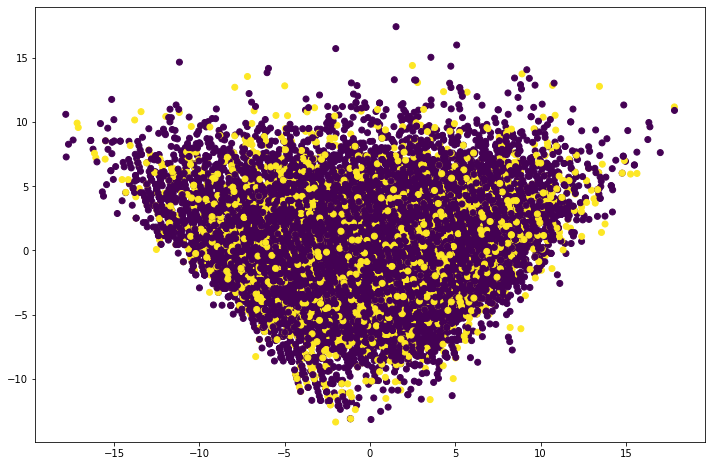

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(pct_values[:,0], pct_values[:,1], c=y)

#### PCA - 3 components

In [19]:
pca_3d = Pipeline([
    ('ct', ct),
    ('pca_3d', PCA(3))
])
pca_values_3d = pca_3d.fit_transform(X)

C:\Users\abdul\anaconda3\lib\site-packages\matplotlib\collections.py:982: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


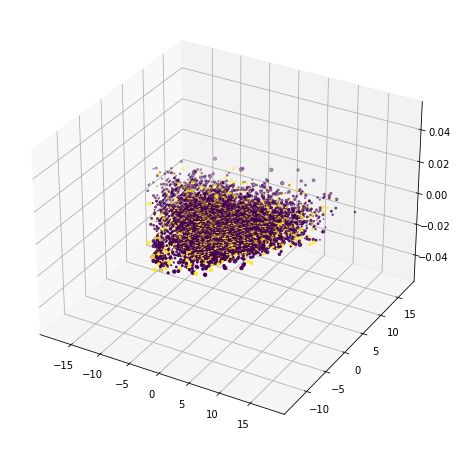

In [20]:
plt.figure(figsize= (12,8)).add_subplot(projection='3d')
plt.scatter(*np.hsplit(pca_values_3d, 3), c=y)
# plt.scatter(pca_values_3d[:,0], pca_values_3d[:,1], pca_values_3d[:,2])

### Model Development

In [49]:
test_data = pd.read_csv('./data/test.csv', index_col=[0])
submission = pd.read_csv('./data/sample_submission.csv')

In [38]:
import lightgbm as lgb

In [39]:
lgb_1 = lgb.LGBMClassifier(max_depth=20,reg_lambda=0.1, random_state=42)
lgb_2 = lgb.LGBMClassifier(max_depth=30,reg_lambda=0.2, random_state=2004)
lgb_3 = lgb.LGBMClassifier(max_depth=40,reg_lambda=0.3, random_state=3302)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [27]:
y_pred

array([0.82462805, 0.17537195])

In [41]:
auc_scores = []
prediction_pipelines = []
for lgbm in [lgb_1, lgb_2, lgb_3]:
    train_pipeline = Pipeline([
        ('ct', ct),
        ('lgb', lgbm)
    ])
    prediction_pipelines.append(train_pipeline)
    train_pipeline.fit(X_train, y_train)
    y_pred = train_pipeline.predict_proba(X_test)[:,1]
    auc_scores.append(roc_auc_score(y_test, y_pred))

In [67]:
auc_scores

[0.5628482521121901, 0.5521535377188617, 0.5606461642106357]

In [57]:
preds = {}

for i, pipeline in enumerate(prediction_pipelines):
    pred = pipeline.predict_proba(test_data)[:,1]
    preds[f'model_{i}']=pred

In [59]:
preds_df = pd.DataFrame(preds)

In [60]:
preds_df['mean'] = preds_df.sum(axis=1)/3

In [61]:
preds_df

,model_0,model_1,model_2,mean
0,0.292141,0.222839,0.219457,0.244813
1,0.155003,0.181526,0.152988,0.163172
2,0.168898,0.183525,0.210979,0.187801
3,0.155512,0.159290,0.223998,0.179600
4,0.152312,0.212180,0.223604,0.196032
...,...,...,...,...
20770,0.176696,0.187878,0.171181,0.178585
20771,0.123731,0.120130,0.133779,0.125880
20772,0.076838,0.139435,0.149586,0.121953
20773,0.184916,0.189667,0.188894,0.187825


In [76]:
preds_df['geom_mean'] = np.cbrt(preds_df.iloc[:,:2].product(axis=1))

In [78]:
preds_df['geom_mean']

0        0.402280
1        0.304154
2        0.314128
3        0.291508
4        0.318527
           ...   
20770    0.321391
20771    0.245872
20772    0.220453
20773    0.327332
20774    0.260698
Name: geom_mean, Length: 20775, dtype: float64

In [79]:
submission['failure'] = preds_df['geom_mean']

In [80]:
submission.to_csv('./data/submission.csv', index=False)

### Hyperparameter optimisation

In [81]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real,Categorical, Integer

In [100]:
space = [
    Integer(2, 100, name='num_leaves'),
    Integer(1,100, name='max_depth'),
    Real(0.1, 0.5, name='learning_rate'),
    Real(0.0005, .5, prior='log-uniform', name='min_split_gain'),
    Real(0.000001, 0.5, name='reg_alpha' ),
    Real(0.000001, 0.5, name='reg_lambda'),
    Integer(0, 3200, name='random_state')
]

In [101]:
@use_named_args(space)
def obj(**params):
    clf = lgb.LGBMClassifier(class_weight={1:5, 0:1})
    clf.set_params(**params)
    
    training_pipeline = Pipeline([
        ('ct', ct),
        ('lgbm', clf)
    ])
    
    training_pipeline.fit(X_train, y_train)
    y_pred = training_pipeline.predict_proba(X_test)[:,1]
    return - roc_auc_score(y_test, y_pred)

In [102]:
import time

In [106]:
start = time.time()
res_gp = gp_minimize(obj,
                    space,
                    n_calls=200,
                    acq_func='EI',
                    n_jobs=-1,
                    verbose=True
                    )
print(time.time()- start)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2685
Function value obtained: -0.5312
Current minimum: -0.5312
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2771
Function value obtained: -0.5336
Current minimum: -0.5336
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.2045
Function value obtained: -0.5358
Current minimum: -0.5358
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3229
Function value obtained: -0.5191
Current minimum: -0.5358
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2882
Function value obtained: -0.5208
Current minimum: -0.5358
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.4695
Function value obtained: -0.5573
Current minimum: -0.5927
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.6160
Function value obtained: -0.5293
Current minimum: -0.5927
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.4721
Function value obtained: -0.5190
Current minimum: -0.5927
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.4746
Function value obtained: -0.5331
Current minimum: -0.5927
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.5758
Function value obtained: -0.5556
Current minimum: -0.5927
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 0.7450
Function value obtained: -0.5246
Current minimum: -0.5927
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 0.6776
Function value obtained: -0.5418
Current minimum: -0.5927
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 0.7749
Function value obtained: -0.5347
Current minimum: -0.5927
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 0.9413
Function value obtained: -0.5449
Current minimum: -0.5927
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 0.6180
Function value obtained: -0.5441
Current minimum: -0.5927
Iteration No: 86 st

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 1.3606
Function value obtained: -0.5403
Current minimum: -0.5928
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 1.0557
Function value obtained: -0.5815
Current minimum: -0.5928
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 1.1160
Function value obtained: -0.5815
Current minimum: -0.5928
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 1.4316
Function value obtained: -0.5329
Current minimum: -0.5928
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 1.2596
Function value obtained: -0.5879
Current minimum: -0.5928
Iteration 

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 1.8624
Function value obtained: -0.5904
Current minimum: -0.5928
Iteration No: 161 started. Searching for the next optimal point.
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 1.8483
Function value obtained: -0.5885
Current minimum: -0.5928
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 2.0320
Function value obtained: -0.5400
Current minimum: -0.5928
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 1.8597
Function value obtained: -0.5904
Current minimum: -0.5928
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 2.1686
Function value obtained: -0.5509
Current minimum: -0.5928
Iteration 

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 3.3973
Function value obtained: -0.5241
Current minimum: -0.5928
Iteration No: 200 started. Searching for the next optimal point.
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 3.0512
Function value obtained: -0.5882
Current minimum: -0.5928
250.60798716545105


In [107]:
res_gp.fun

-0.5928173619569108

In [108]:
res_gp.x

[70,
 1,
 0.10032675444881815,
 0.001561359133480053,
 0.3556260700786376,
 0.3482167621005801,
 2696]

In [116]:
test_pipeline = Pipeline([
    ('ct', ct),
    ('clf', res_gp.[0])
])

test_pipeline.predict(test_data)

ValueError: Anisotropic kernel must have the same number of dimensions as data (7!=24)

In [119]:
trials = pd.DataFrame(res_gp.x_iters)

In [123]:
trials = pd.concat([trials, pd.DataFrame(res_gp.func_vals)], axis=1)

In [125]:
trials.columns = ['num_leaves', 
                  'max_depth',
                  'learning_rate',
                  'min_split_gain',
                  'reg_alpha',
                  'reg_lambda',
                  'seed',
                 'roc_auc']

In [127]:
trials['roc_auc'] = -trials['roc_auc']

In [128]:
trials

,num_leaves,max_depth,learning_rate,min_split_gain,reg_alpha,reg_lambda,seed,roc_auc
0,61,97,0.275331,0.002216,0.203864,0.297648,186,0.531153
1,58,27,0.123006,0.191535,0.279289,0.108401,2859,0.533557
2,22,48,0.313807,0.111855,0.065253,0.122948,1162,0.535767
3,85,66,0.391960,0.498020,0.305837,0.069845,2569,0.519083
4,54,76,0.339461,0.000513,0.477452,0.394349,1462,0.520829
...,...,...,...,...,...,...,...,...
195,42,1,0.106015,0.000777,0.138224,0.164109,3101,0.592580
196,29,23,0.104070,0.101531,0.454733,0.402987,1132,0.552697
197,99,24,0.100273,0.066935,0.385517,0.060547,2995,0.546788
198,39,34,0.497645,0.048080,0.372843,0.062052,31,0.524086


In [164]:
trials.dtypes

num_leaves          int64
max_depth           int64
learning_rate     float64
min_split_gain    float64
reg_alpha         float64
reg_lambda        float64
seed                int64
roc_auc           float64
dtype: object

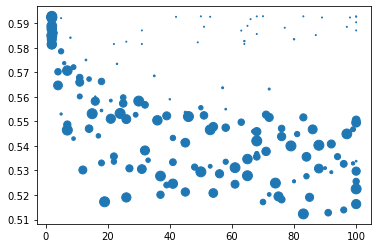

In [134]:
plt.scatter(trials['num_leaves'], trials['roc_auc'], s=trials['max_depth'])

In [139]:
idx = trials[trials['roc_auc'] > 0.575].index

In [142]:
p = trials.columns
above_avg = trials.iloc[idx, :-1]

In [168]:
preds = {}
for row in above_avg.iterrows():
    params = dict(row[1])
    params['seed'] = int(params['seed'])
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    lgbm_clf = lgb.LGBMClassifier(**params)
    clf_pipeline = Pipeline([
        ('ct', ct),
        ('lgb', lgbm_clf)
    ])
    clf_pipeline.fit(X, y)
    preds[f'model_{row[0]}'] = clf_pipeline.predict_proba(test_data)[:,1]

In [170]:
huge_ensemble = pd.DataFrame(preds)

In [171]:
huge_ensemble['mean'] = huge_ensemble.sum(axis=1) / huge_ensemble.shape[1]

In [172]:
huge_ensemble

,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_18,model_26,model_32,...,model_185,model_187,model_188,model_189,model_190,model_191,model_194,model_195,model_199,mean
0,0.190979,0.189598,0.190071,0.191112,0.190429,0.192374,0.191616,0.191782,0.189409,0.189096,...,0.197049,0.191240,0.189376,0.188825,0.188129,0.193490,0.192671,0.188506,0.191152,0.191349
1,0.164195,0.167293,0.167213,0.152096,0.177687,0.176844,0.162744,0.150604,0.174088,0.175527,...,0.164680,0.167187,0.173954,0.175132,0.154440,0.164605,0.150543,0.175364,0.164088,0.167995
2,0.166054,0.175341,0.175541,0.160705,0.183137,0.174727,0.163119,0.158215,0.182881,0.181805,...,0.174810,0.165353,0.182809,0.181342,0.158037,0.167162,0.161979,0.181474,0.166237,0.173637
3,0.158829,0.165585,0.165325,0.154932,0.178121,0.171009,0.154815,0.155545,0.173391,0.174176,...,0.164277,0.156759,0.173263,0.173352,0.156085,0.160310,0.156002,0.176343,0.159110,0.166730
4,0.297409,0.296175,0.296750,0.298551,0.298833,0.276022,0.295203,0.288473,0.296759,0.296653,...,0.296470,0.296742,0.295445,0.297002,0.300779,0.298511,0.300479,0.298201,0.300186,0.296134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20770,0.221829,0.224822,0.222071,0.198290,0.221140,0.223492,0.220258,0.208367,0.221473,0.220912,...,0.216911,0.218901,0.220035,0.221290,0.196211,0.219880,0.199076,0.221107,0.221386,0.218100
20771,0.152234,0.152012,0.151144,0.145247,0.149495,0.135588,0.154708,0.154149,0.149417,0.148788,...,0.155988,0.151368,0.149340,0.148718,0.145225,0.150537,0.147658,0.148825,0.151427,0.149228
20772,0.148694,0.156440,0.155522,0.148268,0.160680,0.145788,0.144975,0.147812,0.159677,0.159771,...,0.153183,0.152011,0.159684,0.159857,0.148386,0.155436,0.150945,0.160408,0.147904,0.155266
20773,0.208574,0.206812,0.206239,0.193966,0.203368,0.204275,0.205482,0.198561,0.205264,0.205805,...,0.207978,0.212451,0.205382,0.205558,0.192414,0.204357,0.195483,0.203321,0.208697,0.203923


In [173]:
submission['failure'] = huge_ensemble['mean']

In [174]:
submission.to_csv('./data/submission.csv', index=False)